# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# csv file
df = pd.read_csv('../input/scrapped-lyrics-from-6-genres/lyrics-data.csv')
# Getting songs written by one author
df = df[df['ALink']=="/elvis-presley/"]
# Training on English songs only
df.drop(['ALink','SName','SLink'],axis=1,inplace=True)
df = df[df['Idiom']=='ENGLISH']

In [3]:
# Due to lack of memory, we can't train on the whole dataset, we need to
# take only a portion of it
# take first 1000 rows
# df = df[:1000]

In [4]:
# shape
df.shape

(771, 2)

# Data Preprocessing

In [5]:
# Tokenization
tokenizer = Tokenizer(filters='0123456789!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
# Used to preprocess the text, by removing the comma and
# other punctuations for example. We also removed numbers
# It also splits the sentences to words, and turns all words
# into lower case

tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())
# Applying the tokenizer

total_words = len(tokenizer.word_index)+1 
# We add one to the index, as index starts from zero

tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
# Turns the words into integer type by classifying them according to word dictionary.
tokenized_sentences[0]
# Checking the first element, to understand what happened

[5,
 34,
 1,
 304,
 19,
 380,
 5,
 22,
 2,
 252,
 1,
 2710,
 1941,
 8,
 259,
 47,
 72,
 16,
 842,
 47,
 1393,
 8,
 1202,
 10,
 776,
 18,
 1283,
 83,
 712,
 4,
 97,
 77,
 469,
 83,
 2256,
 224,
 5,
 125,
 1007,
 5,
 81,
 151,
 81,
 209,
 60,
 2,
 183,
 16,
 8,
 69,
 1942,
 83,
 112,
 4,
 891,
 24,
 94,
 137,
 102,
 891,
 6,
 1008,
 2,
 183,
 41,
 2,
 112,
 6,
 38,
 5,
 276,
 16,
 130,
 186,
 2711,
 2,
 1203,
 224,
 2712,
 2257,
 224,
 1943,
 290,
 194,
 1,
 2258,
 21,
 5,
 81,
 151,
 81,
 209,
 60,
 2,
 183,
 16,
 8,
 69,
 120,
 64,
 163,
 326,
 18,
 280,
 3,
 260,
 26,
 2,
 421,
 239,
 81,
 209,
 2,
 104,
 2713,
 24,
 130,
 16,
 20,
 26,
 64,
 54,
 477,
 2,
 2714,
 16,
 68,
 5,
 2715,
 16,
 78,
 2,
 2259,
 16,
 20,
 5,
 2,
 713,
 587,
 5,
 183,
 16,
 8,
 69,
 83,
 261,
 83,
 1067,
 5,
 494,
 83,
 112,
 8,
 2716,
 8,
 390,
 10,
 1701,
 5,
 34,
 66,
 277,
 2717,
 2,
 153,
 16,
 20,
 22,
 2718,
 6,
 126,
 2,
 183,
 20,
 12,
 5,
 159,
 2,
 72,
 85,
 9,
 4,
 1284,
 69,
 21,
 30,
 30,
 85,
 

In [6]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
# Having reached this point, input_sequences contains array of lists of words, starting from
# a list containg 2 words, then we append a third word to them, then another word, and so on.
# This causes a problem, as the length of the lists are not equal, so we pad them by adding zeros
# at the beginnig, till they are all of the same length (the maximum length)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences]) 
# Gets the length of the longest list in the 
# array of lists
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [7]:
# Taking a look at how this process works
#testlyna= list()
#for i in tokenized_sentences:
#    for t in range(1, len(i)):
#        n_gram_sequence = i[:t+1]
#        testlyna.append(n_gram_sequence)
#        if t==250:
#            break
#    break
#print(testlyna)

In [8]:
input_sequences[:10]
# Making sure everything is as we expected

array([[  0,   0,   0, ...,   0,   5,  34],
       [  0,   0,   0, ...,   5,  34,   1],
       [  0,   0,   0, ...,  34,   1, 304],
       ...,
       [  0,   0,   0, ...,   5,  22,   2],
       [  0,   0,   0, ...,  22,   2, 252],
       [  0,   0,   0, ...,   2, 252,   1]], dtype=int32)

In [9]:
# Dividing the data into X, y -----> the training set, and the labels to be predicted
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
# Takes all elemnts in each row, except the last element, and places them in X
# while labels takes the last element (the element which we should predict)

y = tf.keras.utils.to_categorical(labels, num_classes=total_words) # One hot encoding
# number of classes is now equal to the number of unique words in the song lyrics

# Model

We will not going to create RNN model due to its vanishing gradient problem instead of that we will going to create LSTM model.LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively.

In [10]:
# creating model
model = Sequential()

In [11]:
max_sequence_len

451

In [12]:
#model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
# dimension of input: total_words, the number of unique words we have
# 40: the desired dimension of the output
# input_length: the sequence length is all the words except the last one (the one
# we will predict)
model.add(Bidirectional(LSTM(250))) # 250 is the average number of words in a song
# So our cycle is the average length of a song
# We used LSTM instead of simple RNN as simple RNN faces a vanishing gradient
# problem, also, we need to remember the previous words, to predict the next words.

model.add(Dropout(0.1)) # To overcome overfitting
model.add(Dense(total_words, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 450, 40)           230440    
_________________________________________________________________
bidirectional (Bidirectional (None, 500)               582000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 5761)              2886261   
Total params: 3,698,701
Trainable params: 3,698,701
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Call backs
#checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True) # dh el code el by-save el model

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
# el mfrood dh by5leeh asr3

earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto') # To overcome overfitting
# dh 3lshan yo2of abl ma y3ml overfitting, bs badeelo forsa 10 epochs

#callback_list = [checkpoint, early_stopping, reduce_lr]
callback_list = [earlystop, reduce_lr]

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.fit(X, y, epochs=20, callbacks=callback_list)

Epoch 1/20
3717/3717 [==============================] - 320s 85ms/step - loss: 6.3152 - accuracy: 0.0532
Epoch 2/20
3717/3717 [==============================] - 312s 84ms/step - loss: 5.1242 - accuracy: 0.1355
Epoch 3/20
3717/3717 [==============================] - 311s 84ms/step - loss: 4.3833 - accuracy: 0.2032
Epoch 4/20
3717/3717 [==============================] - 311s 84ms/step - loss: 3.7911 - accuracy: 0.2732
Epoch 5/20
3717/3717 [==============================] - 312s 84ms/step - loss: 3.3445 - accuracy: 0.3343
Epoch 6/20
3717/3717 [==============================] - 314s 84ms/step - loss: 2.9851 - accuracy: 0.3894
Epoch 7/20
3717/3717 [==============================] - 315s 85ms/step - loss: 2.6596 - accuracy: 0.4426
Epoch 8/20
3717/3717 [==============================] - 315s 85ms/step - loss: 2.4355 - accuracy: 0.4794
Epoch 9/20
3717/3717 [==============================] - 313s 84ms/step - loss: 2.2260 - accuracy: 0.5197
Epoch 10/20
3717/3717 [==============================] 

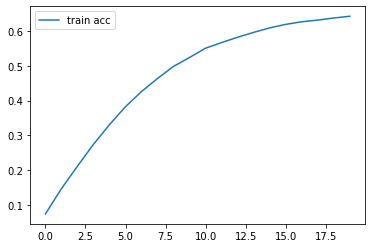

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the accuracy
plt.plot(model.history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Generate new song lyrics

In [18]:
# el input_text dh el text elly badeehlo, w bykamel 3leh el o8nya
# next_words dyh 3adad el kalemat el hy3mlha prediction
def complete_this_song(input_text, next_words):
    for _ in range(next_words):
        # for _ in... this is like a place holder, which upholds the syntax.
        # We use it when we don't want to use the variable, so we leave it empty.
        
        # Doing the same things to the input as we did when training the model
        token_list = tokenizer.texts_to_sequences([input_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                # Gets the word corresponding the the value predicted
                # [Converting from numeric to string again]
                output_word = word
                break
        input_text += " " + output_word
    return input_text

Our function is ready so are you ready to generate your own lyrics

In [19]:
complete_this_song("the sky is blue", 40)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'the sky is blue or as the king of the ages wild in the sky and the last blue skies above i love the stranger in the sky sparrow sparrow hear the earth love is here and the years will be our song i'

In [20]:
complete_this_song("This is the beginning", 140)

"This is the beginning of the man of the children they hear the moon they never kissed the doubt the music mountains the wide has got no care of the room of the hare maybellene why can't you be true you've started back doing the things you used to do the cadillac moved and he will be down or when he plays not a fast but we can dance my mind is gonna wait to be coming our way we walk along the way i wanna know gotta know i would be a tame and he keeps a man that i was so tied i got a feelin' in my body this will be our lucky day we'll be releasing all our sorrow leave it layin' along the way won't you lift your head up high and they're standing on a closing way to"

In [21]:
complete_this_song("I am missing you", 80)

"I am missing you know that i was almost always true to you my love is true i know that i love you so i love you so darling my love is true true as love you're all the love i love you and i love you and i always will love me never tell me that your love is all of love will you know darling i'll be there to you always be mine darling i'll be mine i'll be blue i'll be"

In [22]:
complete_this_song("I love you", 40)

'I love you so i lie and i lose the door of you i know that i love you so how i have lost my own hand and the memory of your love and the one who knew i ever knew in the'

In [ ]:
# save model
from tensorflow.keras.models import load_model
model.save('song_lyrics_generator.h5')